In [ ]:
from google.colab import drive
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your zip file
zip_file_path = '/content/drive/MyDrive/ESCC/Endoscopy-esophagus.zip'  # Update the path

# Specify the folder where you want to extract the contents
extraction_path = '/content/drive/MyDrive/ESCC'  # Update the folder path

# Unzip using zipfile
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"File extracted to {extraction_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File extracted to /content/drive/MyDrive/ESCC


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def check_green_box(image_path):
    """
    Check if there's a green box in the bottom-left corner of the image.
    """
    image = cv2.imread(image_path)
    if image is None:
        return False  # If image is not loaded properly

    # Get image dimensions
    height, width, _ = image.shape

    # Define bottom-left region (adjust size based on green box size)
    region = image[int(0.8 * height):, :int(0.3 * width)]

    # Convert to HSV color space for better color detection
    hsv = cv2.cvtColor(region, cv2.COLOR_BGR2HSV)

    # Define green color range (adjust values if needed)
    lower_green = np.array([35, 50, 50])   # Lower bound for green
    upper_green = np.array([85, 255, 255]) # Upper bound for green

    # Create mask for green color detection
    mask = cv2.inRange(hsv, lower_green, upper_green)
    green_pixels = cv2.countNonZero(mask)

    # If green pixels exceed a threshold, consider it a green box
    if green_pixels > 500:  # Adjust this threshold based on box size
        return True
    return False

def classify_images(source_folder, target_folder_with_box, target_folder_without_box):
    """
    Analyze all images in the source folder and classify them based on the green box.
    """
    if not os.path.exists(target_folder_with_box):
        os.makedirs(target_folder_with_box)

    if not os.path.exists(target_folder_without_box):
        os.makedirs(target_folder_without_box)

    for filename in tqdm(os.listdir(source_folder)):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(source_folder, filename)
            if check_green_box(image_path):
                cv2.imwrite(os.path.join(target_folder_with_box, filename), cv2.imread(image_path))
            else:
                cv2.imwrite(os.path.join(target_folder_without_box, filename), cv2.imread(image_path))

# Paths
source_folder = "/content/drive/MyDrive/ESCC/no-esophagus"  # Folder containing all 8500 images
target_folder_with_box = "/content/drive/MyDrive/ESCC/no-esophagus/withbox"  # Folder for images with green box
target_folder_without_box = "/content/drive/MyDrive/ESCC/no-esophagus/extracted_images"  # Folder for images without green box

# Run classification
classify_images(source_folder, target_folder_with_box, target_folder_without_box)

100%|██████████| 8975/8975 [12:40<00:00, 11.80it/s]


In [ ]:
import albumentations as A
from albumentations.augmentations import transforms
import cv2
import os

# Augmentation pipeline
augment = A.Compose([
    A.Rotate(limit=20),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
    A.GaussianBlur(blur_limit=3),
    A.ElasticTransform(alpha=1),
])

source_path = "/content/drive/MyDrive/ESCC/esophagus"
augmented_path = "/content/drive/MyDrive/ESCC/esophagus/augmented_images"
os.makedirs(augmented_path, exist_ok=True)

original_count = len(os.listdir(source_path))
images_needed = 3232 - original_count

i = 0
for img_name in os.listdir(source_path):
    img_path = os.path.join(source_path, img_name)
    img = cv2.imread(img_path)

    if img is None:
        continue

    while i < images_needed:
        augmented_img = augment(image=img)['image']
        save_path = os.path.join(augmented_path, f"aug_{i}.jpg")
        cv2.imwrite(save_path, augmented_img)
        i += 1

print(f"Advanced augmentation completed. {images_needed} images generated!")

Advanced augmentation completed. 1542 images generated!


In [ ]:
import albumentations as A
import cv2
import os
import numpy as np
from tqdm import tqdm

# Paths
source_path = "/content/drive/MyDrive/ESCC/esophagus"
augmented_path = "/content/drive/MyDrive/ESCC/esophagus"
os.makedirs(augmented_path, exist_ok=True)

# Count images
original_images = os.listdir(source_path)
original_count = len(original_images)
target_count = 4232
images_needed = target_count - original_count

# Augmentation Pipeline
augment = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.3),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
])

print(f"Original Images: {original_count}, Augmenting to: {target_count}")

# Augmentation Loop
augmented_count = 0
while augmented_count < images_needed:
    for img_name in tqdm(original_images, desc="Augmenting Images"):
        if augmented_count >= images_needed:
            break
        img_path = os.path.join(source_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        # Apply augmentation
        augmented_img = augment(image=img)['image']
        save_path = os.path.join(augmented_path, f"aug_{augmented_count}.jpg")
        cv2.imwrite(save_path, augmented_img)
        augmented_count += 1

print(f"Augmentation completed! Generated {images_needed} augmented images.")

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-2-2562ae2f364f>:26: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),


Original Images: 1689, Augmenting to: 4232


Augmenting Images:  51%|█████     | 854/1689 [01:32<01:30,  9.20it/s]

Augmentation completed! Generated 2543 augmented images.


In [ ]:
import cv2
import numpy as np
import os

# Function to process each image
def process_image(image_path):
    # Load the endoscopy image in color (BGR format)
    image = cv2.imread(image_path)

    # Check if image loaded successfully
    if image is None:
        print(f"Error: Image not found at {image_path}")
        return None

    # Split the image into its BGR channels
    b, g, r = cv2.split(image)

    # Apply CLAHE to each channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    b_clahe = clahe.apply(b)
    g_clahe = clahe.apply(g)
    r_clahe = clahe.apply(r)

    # Merge the enhanced BGR channels back
    clahe_image = cv2.merge((b_clahe, g_clahe, r_clahe))

    # Create Unsharp Masking
    # Apply Gaussian blur to each channel
    b_blurred = cv2.GaussianBlur(b_clahe, (5, 5), 1.5)
    g_blurred = cv2.GaussianBlur(g_clahe, (5, 5), 1.5)
    r_blurred = cv2.GaussianBlur(r_clahe, (5, 5), 1.5)

    # Subtract the blurred images from the original CLAHE-enhanced images
    b_sharpened = cv2.addWeighted(b_clahe, 1.5, b_blurred, -0.5, 0)
    g_sharpened = cv2.addWeighted(g_clahe, 1.5, g_blurred, -0.5, 0)
    r_sharpened = cv2.addWeighted(r_clahe, 1.5, r_blurred, -0.5, 0)

    # Merge the sharpened channels back
    final_image = cv2.merge((b_sharpened, g_sharpened, r_sharpened))

    return final_image

# Directory containing the images
input_directory = '/content/drive/MyDrive/ESCC/no-esophagus/extracted_images'

# Directory to save enhanced images
output_directory = '/content/drive/MyDrive/ESCC1/diseased'

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# List all files in the directory
image_files = [f for f in os.listdir(input_directory) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Loop through each image file in the directory
for image_file in image_files:
    image_path = os.path.join(input_directory, image_file)
    enhanced_image = process_image(image_path)

    if enhanced_image is not None:
        # Save the enhanced image
        output_image_path = os.path.join(output_directory, f"enhanced_{image_file}")
        cv2.imwrite(output_image_path, enhanced_image)
        print(f"Saved enhanced image: {output_image_path}")


Saved enhanced image: /content/drive/MyDrive/ESCC1/diseased/enhanced_c490fdf6-9cf9-4dc7-b497-2ab5c19f2c00.jpg
Saved enhanced image: /content/drive/MyDrive/ESCC1/diseased/enhanced_c4936df8-80de-498c-a236-1d9146102154.jpg
Saved enhanced image: /content/drive/MyDrive/ESCC1/diseased/enhanced_c4a13518-1519-4579-aa66-c689de9d3f47.jpg
Saved enhanced image: /content/drive/MyDrive/ESCC1/diseased/enhanced_c4b5fc20-418e-4cb8-8dba-018731d6feb3.jpg
Saved enhanced image: /content/drive/MyDrive/ESCC1/diseased/enhanced_c4b7070e-ad54-42e6-9ca1-dbb146c3b8d8.jpg
Saved enhanced image: /content/drive/MyDrive/ESCC1/diseased/enhanced_c4c9fb68-fa04-4ebe-9718-ba89fa847eab.jpg
Saved enhanced image: /content/drive/MyDrive/ESCC1/diseased/enhanced_c4ceaa9d-e09c-4e2a-918d-721dbc587579.jpg
Saved enhanced image: /content/drive/MyDrive/ESCC1/diseased/enhanced_c4d507c0-deb5-4e7a-8e75-67fa4f976e04.jpg
Saved enhanced image: /content/drive/MyDrive/ESCC1/diseased/enhanced_c4d5a209-02d4-4dd0-8534-666f82b69d6c.jpg
Saved enha

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import os

# Paths
dataset_path = '/content/drive/MyDrive/ESCC1'
img_size = 224
batch_size = 32

# Data augmentation and loading
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Load pre-trained VGG16 model + exclude top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Custom classification head
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)
model.save("/content/drive/MyDrive/ESCC1/models/VGG16_base_clahe_gausianblur.h5")

Found 6772 images belonging to 2 classes.
Found 1692 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import os

# Paths
dataset_path = '/content/drive/MyDrive/ESCC1'
img_size = 224
batch_size = 32

# Data augmentation and loading
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 6772 images belonging to 2 classes.
Found 1692 images belonging to 2 classes.


In [ ]:
print(train_generator.class_indices)
# Likely: {'diseased': 0, 'non-diseased': 1} or vice versa

{'diseased': 0, 'non_diseased': 1}


In [ ]:
model.save("/content/drive/MyDrive/ESCC1/models/VGG16_base_clahe_gausianblur.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━

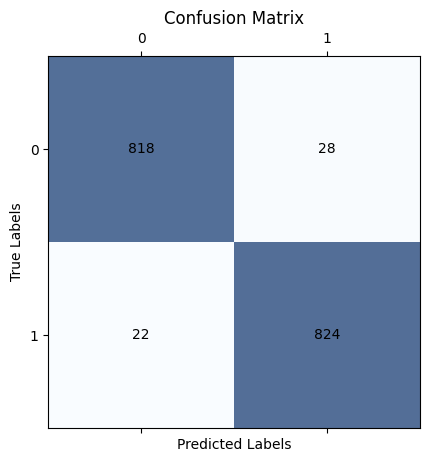

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/models/VGG16_base_clahe_gausianblur.h5")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Get the total number of samples in the validation set
total_samples = len(val_generator.filenames)

# Initialize lists to collect all true labels and predicted probabilities
all_true_labels = []
all_pred_probs = []

# Loop through all batches in the validation generator
for i in range(len(val_generator)):
    x_batch, y_true_batch = val_generator[i]  # Get the i-th batch
    all_true_labels.extend(y_true_batch)
    y_pred_prob_batch = model.predict(x_batch)
    all_pred_probs.extend(y_pred_prob_batch)

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_pred_probs = np.array(all_pred_probs)

# Set the optimal threshold and get predicted labels
optimal_threshold = 0.5
all_pred_labels = (all_pred_probs >= optimal_threshold).astype(int)

# Classification Report
print("Classification Report:")
print(classification_report(all_true_labels, all_pred_labels))

# Confusion Matrix
cm = confusion_matrix(all_true_labels, all_pred_labels)
plt.matshow(cm, cmap='Blues', alpha=0.7)
for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title("Confusion Matrix")
plt.show()


Found 1692 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 1106s 21s/step


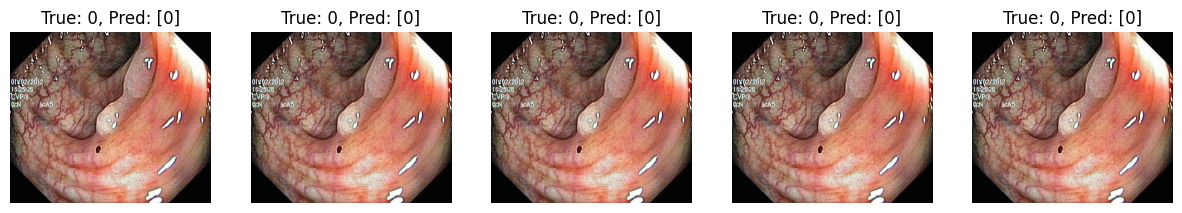

              precision    recall  f1-score   support

           0       0.49      0.49      0.49       846
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00       846

    accuracy                           0.24      1692
   macro avg       0.16      0.16      0.16      1692
weighted avg       0.25      0.24      0.24      1692



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

# Load the trained model
model_path = '/content/drive/MyDrive/ESCC1/models/VGG16_base_clahe_gausianblur.h5'
model = load_model(model_path)

# Data generator for validation set (ensure this matches your validation setup)
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Make predictions on the validation data
predictions = model.predict(val_generator)

# Get the true labels
y_true = val_generator.classes  # True labels from the generator
y_pred = (predictions > 0.5).astype("int32")  # Predicted labels (binary classification)

# Find the indices of incorrect predictions
incorrect_indices = np.where(y_true != y_pred)[0]

# Plot some incorrect predictions
num_images_to_show = 5  # You can modify how many images to show
plt.figure(figsize=(15, 10))

for i in range(num_images_to_show):
    index = incorrect_indices[i]
    image_path = val_generator.filepaths[index]

    # Load the image from file
    image = plt.imread(image_path)

    # Get the true and predicted labels
    true_label = y_true[index]
    predicted_label = y_pred[index]

    # Display the image with the corresponding labels
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(image)
    plt.title(f"True: {true_label}, Pred: {predicted_label}")
    plt.axis('off')

plt.show()

# Optionally print classification report for a deeper analysis
print(classification_report(y_true, y_pred))
